# Movie Recommendation System EDA & Insights

**Author:** Orimoloye Marvelous 
**Date:** April 2025  
**Location:** Lagos, Nigeria  

**Datasource:**  
MovieLens-style dataset (https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) 


**Project Objective**  
Exploratory Data Analysis (EDA) of a sparse movie ratings dataset to uncover patterns in user preferences, genre performance, tag usage, and sparsity implications — laying the foundation for building an effective movie recommendation system (collaborative filtering, content-based, hybrid approaches).

**Key Areas of Focus**  
- Rating distribution & sparsity analysis  
- Genre popularity vs. average rating  
- User tag behavior & thematic clusters  
- Implications for cold-start, long-tail, and model selection  
- User-Movie ratings matrix   
**Tools & Technologies**
  
Python, Pandas, NumPy, Matplotlib/Seaborn (visualizations), Scikit-learn / Surprise (future modeling)



In [25]:
import pandas as pd
import os

# Load Data
BASE = '../data/ml-latest-small'
ratings = pd.read_csv(os.path.join(BASE, 'ratings.csv'))
movies  = pd.read_csv(os.path.join(BASE, 'movies.csv'))
links   = pd.read_csv(os.path.join(BASE, 'links.csv'))
tags   = pd.read_csv(os.path.join(BASE, 'tags.csv'))
print("Ratings shape:", ratings.shape)          
print("Movies shape: ", movies.shape)           
print("Unique users: ", ratings['userId'].nunique())   
print("Unique movies rated:", ratings['movieId'].nunique()) 
print("\nSample rating:\n", ratings.head(3))
print("\nSample movie:\n", movies.head(3))

Ratings shape: (100836, 4)
Movies shape:  (9742, 3)
Unique users:  610
Unique movies rated: 9724

Sample rating:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224

Sample movie:
    movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  


# Merge The Data

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-v0_8')  
sns.set_palette("viridis")


# Quick merges for convenience 
df = ratings.merge(movies, on='movieId', how='left')
print("Merged shape:", df.shape)
df.head(3)

Merged shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller


# Basic Information
## Handling Missing Values and Duplicates

In [12]:
# Shapes & dtypes
print("Ratings:\n", ratings.info())
print("\nMovies:\n", movies.info())

# Missing values
print("\nMissing in ratings:\n", ratings.isnull().sum())
print("Missing in movies:\n", movies.isnull().sum())

# Duplicates?
print("\nDuplicate rows in ratings:", ratings.duplicated().sum())

<class 'pandas.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
Ratings:
 None
<class 'pandas.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  9742 non-null   int64
 1   title    9742 non-null   str  
 2   genres   9742 non-null   str  
dtypes: int64(1), str(2)
memory usage: 228.5 KB

Movies:
 None

Missing in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing in movies:
 movieId    0
title      0
genres     0
dtype: int64

Duplicate rows in ratings: 0


# Distrubution of Ratings

C:\Users\ws\AppData\Local\Temp\ipykernel_7120\3850414566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


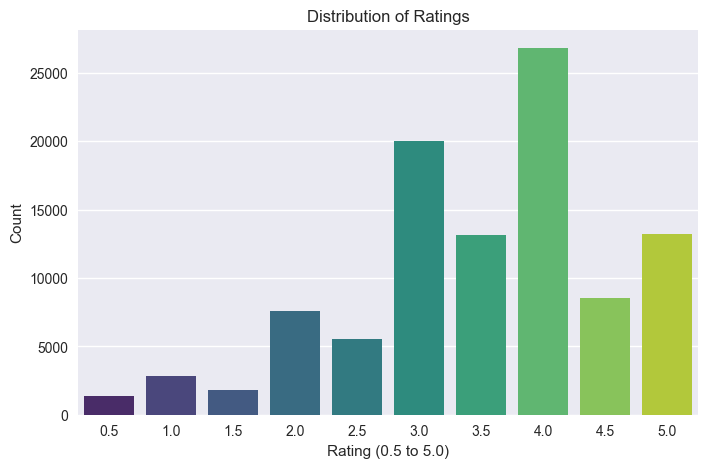

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Most common rating: 4.0


In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating (0.5 to 5.0)')
plt.ylabel('Count')
plt.show()

# Stats
print(ratings['rating'].describe())
print("\nMost common rating:", ratings['rating'].mode()[0])

### Ratings – Key Insights

- **Strong positive bias**: Peaks at **4.0** and **5.0**.  
  Users mostly rate movies they like → optimism (positive bias).

- **Most common rating**: **4.0** (mode)

- **Central tendency**:  
  Mean ≈ **3.50**  
  Median = **3.5**  
  → Mildly optimistic (above neutral 3.0)

- **Spread**: Std ≈ **1.04** — moderate, not extremely polarized

- **Granularity**: Half-star increments (0.5–5.0) → better nuance for modeling



# User & Item Activity (Long-Tail & Sparsity)

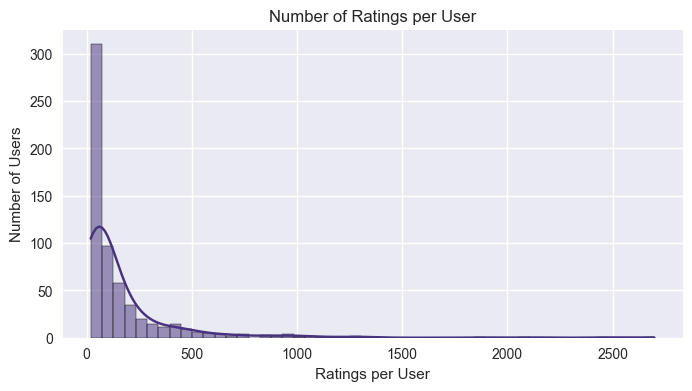

Users stats:
 count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64


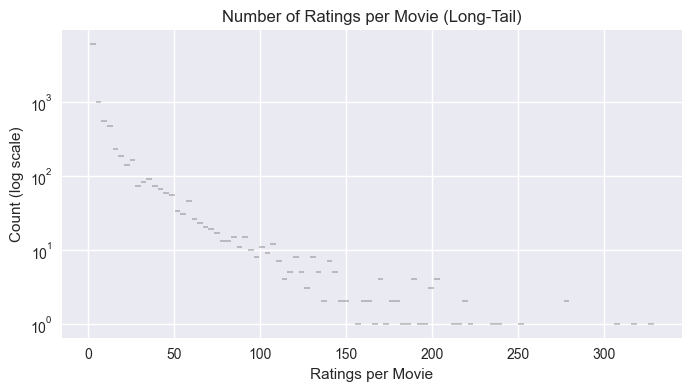

Movies stats:
 count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64


In [18]:
# Ratings per user
user_counts = ratings.groupby('userId')['movieId'].count()
plt.figure(figsize=(8,4))
sns.histplot(user_counts, bins=50, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.show()

print("Users stats:\n", user_counts.describe())

# Ratings per movie
movie_counts = ratings.groupby('movieId')['rating'].count()
plt.figure(figsize=(8,4))
sns.histplot(movie_counts, bins=100, log_scale=(False, True)) 
plt.title('Number of Ratings per Movie (Long-Tail)')
plt.xlabel('Ratings per Movie')
plt.ylabel('Count (log scale)')
plt.show()

print("Movies stats:\n", movie_counts.describe())

### Users & Movies Distribution – Key Insights

#### 1. User Activity (610 users total)
- Ratings per user show a **right-skewed distribution** with a long tail of "power users".
- **Median user** rates **71 movies** → most users provide modest feedback.
- **Mean = 165 ratings** → heavily pulled upward by enthusiastic users.
- Range: 20 (minimum) → 2,698 (maximum)  
  → No true cold-start users in this subset, but huge variation in engagement.
- This is why pure collaborative filtering can struggle with unpopular items.

**Users summary stats**:
```text
count      610.000
mean       165.305
std        269.481
min         20.000
25%         35.000
50%         70.500
75%        168.000
max       2698.000

# Sparsity Calculation

In [21]:
n_users = ratings['userId'].nunique()     
n_movies = movies['movieId'].nunique()    
n_ratings = len(ratings)                   

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"User-Movies matrix sparsity: {sparsity:.4%}")

User-Movies matrix sparsity: 98.3032%


#### Matrix Sparsity
- **User-Movies rating matrix sparsity**: **98.30%**
- **Density** (percentage of known ratings): **1.70%**

This means **only ~1.7%** of all possible user-movie combinations actually contain a rating → extremely sparse dataset.
#### Main Implications of 98.3% Sparsity

1. **Cold-start problem is severe**  
   → Most users have rated very few movies (and most movies have very few ratings)

2. **Memory-based collaborative filtering will struggle**  
   → User-user or item-item similarity computation becomes unreliable due to very few co-rated items

3. **Matrix factorization methods are usually more appropriate**  
   → SVD, FunkSVD, or hybrid approaches tend to perform better in this regime

4. **High risk of overfitting** when using deep models without regularization

5. **Popularity bias will be very strong**  
   → A small number of blockbuster movies dominate the ratings → long-tail movies are hard to recommend

6. **Evaluation needs careful design**  
  



# Average rating per genre

C:\Users\ws\AppData\Local\Temp\ipykernel_7120\793027627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


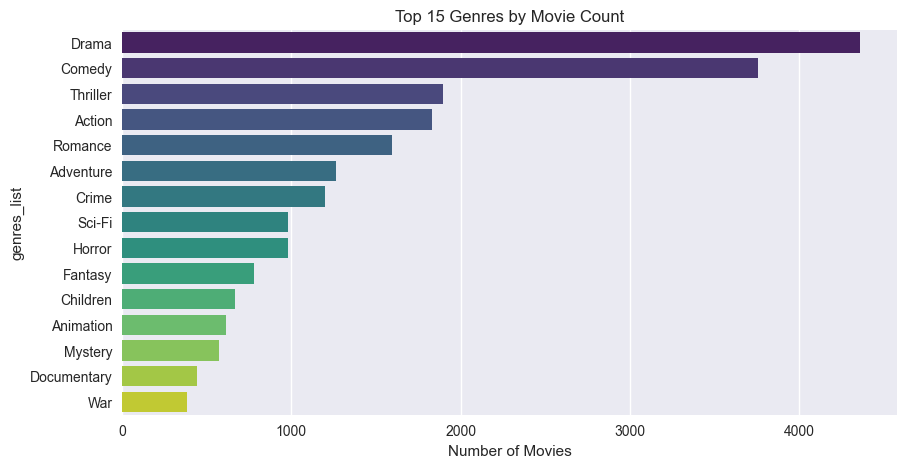

In [28]:
# Explode genres
movies['genres_list'] = movies['genres'].str.split('|')
genres_exploded = movies.explode('genres_list')

# Top genres
top_genres = genres_exploded['genres_list'].value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 15 Genres by Movie Count')
plt.xlabel('Number of Movies')
plt.show()


In [23]:
genre_ratings = df.assign(genres_list=df['genres'].str.split('|')).explode('genres_list')
genre_avg = genre_ratings.groupby('genres_list')['rating'].agg(['mean','count']).sort_values('mean', ascending=False)
print(genre_avg.head(10))

                 mean  count
genres_list                 
Film-Noir    3.920115    870
War          3.808294   4859
Documentary  3.797785   1219
Crime        3.658294  16681
Drama        3.656184  41928
Mystery      3.632460   7674
Animation    3.629937   6988
IMAX         3.618335   4145
Western      3.583938   1930
Musical      3.563678   4138


#### Main Insights from Genre Ratings

1. **Niche genres receive the highest praise**  
   - Film-Noir (3.92), War (3.81), and Documentary (3.80) lead — users appear to rate these more generously when they do watch/rate them.  
   - These genres also have **far fewer ratings**, suggesting higher selectivity (only enthusiasts rate them).

2. **Drama dominates volume**  
   - Drama has **41,928 ratings** — almost 2.5× more than Crime (2nd most rated).  
   - Despite huge volume, it still maintains a strong 3.66 average → very robust genre.

3. **Weak negative correlation** between popularity and rating  
   - Correlation(count, mean_rating) ≈ **-0.20**  
   - More-rated genres tend to have slightly lower averages (classic popularity bias / mainstream effect), though the relationship is not very strong.

4. **Lowest-rated genres among the top**  
   - Musical (3.56), Western (3.58), IMAX (3.62) — possibly more polarizing or context-dependent experiences.

5. **Recommendation strategy implications**  
   - **Exploration potential**: Film-Noir, War, and Documentaries are high-reward for users willing to try less mainstream content.  
   - **Safe bets**: Drama, Crime, Mystery, Animation — high volume + solid ratings → good for cold-start & broad appeal.  
   - **Long-tail opportunity**: Genres like Film-Noir and Documentary suffer from severe under-exposure (very low count) despite excellent ratings.

# Top Tags

In [26]:
print("Unique tags:", tags['tag'].nunique())
top_tags = tags['tag'].value_counts().head(20)
print(top_tags)

Unique tags: 1589
tag
In Netflix queue      131
atmospheric            36
superhero              24
thought-provoking      24
funny                  23
Disney                 23
surreal                23
religion               22
sci-fi                 21
dark comedy            21
quirky                 21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
music                  16
time travel            16
mental illness         16
Name: count, dtype: int64


#### Main Insights from Tag Data

1. **Dominant personal utility tag**  
   - "In Netflix queue" (131 occurrences) is **~5–8× more frequent** than any other tag → this is clearly a **personal watchlist / intent-to-watch** marker, not a content descriptor.  
   → It inflates the tag count significantly and should probably be filtered out when doing content-based or semantic analysis.

2. **Mood & style tags lead content descriptors**  
   Top recurring descriptive tags:  
   - atmospheric (36), surreal (23), quirky (21), visually appealing (19)  
   → Users seem particularly sensitive to **tone, atmosphere, and visual/aesthetic experience** rather than just plot or genre.

3. **Thoughtful / intellectual themes are prominent**  
   - thought-provoking (24), psychology (21), mental illness (16), religion (22), politics (18)  
   → Strong presence of tags related to deep, reflective, or psychologically/socially complex content.

4. **Genre & trope tags appear, but are not dominant**  
   - superhero (24), sci-fi (21), crime (19), time travel (16), dark comedy (21), suspense (20)  
   → These are present but outnumbered by mood/style tags → content-based filtering might benefit more from tone descriptors than strict genres.

5. **Very long tail**  
   - 1,589 unique tags but top tag = 131, top 20 ≈ 600–650 occurrences → **~60–70% of tags appear only once or a handful of times**.  
   → Classic power-law / long-tail distribution → tag-based recommenders will need careful handling (grouping, embeddings, or frequency thresholds).

6. **Implication for recommendation approaches**  
   - **Tag-based / content-based filtering** → promising, especially using atmospheric, thought-provoking, surreal, quirky, psychology clusters  
   - **Hybrid models** → combine these descriptive tags with collaborative signals (very sparse matrix)  
   - **Watchlist filtering** → exclude/remove "In Netflix queue" before most tag analyses to avoid bias

**Tag Usage Snapshot**

- Total unique tags: **1,589**
- Most frequent tag: **In Netflix queue** (131) → personal watchlist marker
- Top descriptive tags: atmospheric (36), superhero (24), thought-provoking (24), surreal (23), quirky (21)
- Dominant themes: **Mood & atmosphere** > Intellectual/psychological > Genre/trope
- Distribution: **Heavy long tail** — most tags are rare

**Recommendation takeaway**  
→ Users tag heavily on **feeling/tone** (atmospheric, surreal, quirky, visually appealing) and **mental depth** (thought-provoking, psychology, mental illness) → strong signal for personalized discovery beyond blockbuster genres.